# Introduction to the xgbsurv package

This notebook introduces `xgbsurv` using a specific dataset. It structured by the following steps:

- Load data
- Load model
- Fit model
- Predict and evaluate model

The syntax conveniently follows that of sklearn.

In [1]:
from xgbsurv.datasets import (load_metabric, load_flchain, load_rgbsg, load_support, load_tcga)
from xgbsurv import XGBSurv
from xgbsurv.evaluation import cindex_censored, ibs
from xgbsurv.models.utils import sort_X_y
import os
import numpy as np
import pandas as pd
from scipy.stats import uniform as scuniform
from scipy.stats import randint as scrandint
from scipy.stats import loguniform as scloguniform 
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.decomposition import PCA
# import models
from xgbsurv.models.eh_aft_final import aft_likelihood, get_cumulative_hazard_function_aft
from pycox.evaluation import EvalSurv
from xgbsurv.models.utils import sort_X_y_pandas, transform_back, transform
from xgbsurv.preprocessing.dataset_preprocessing import discretizer_df
from sklearn.utils.fixes import loguniform
np.random.seed(42)

In [6]:
param_grid = {
'estimator__reg_alpha': scloguniform(1e-10,1),#[1e-10,1], # from hyp augmentation, L1 regularization
'estimator__reg_lambda': scloguniform(1e-10,1), #[1e-10,1], #alias l2_regularization, lambda in augmentation
'estimator__learning_rate': scloguniform(0.01,1.0), #[0.001,1], # assumed alias eta from augmentation,
'estimator__n_estimators':  scrandint(1,500),#00), # corresponds to num_rounds
'estimator__gamma': loguniform(0.001,1-0.5),#[0.1,1], # minimum loss reduction required to make a further partition on a leaf node of the tree.
'estimator__colsample_bylevel': scuniform(0.1, 1-0.1), #[0.1,1], # from hyp augmentation
'estimator__colsample_bynode': scuniform(0.1, 1-0.1), #[0.1,1], # from hyp augmentation, uniform(0.1,1),
'estimator__colsample_bytree': scuniform(0.5, 1-0.5),#[0.5,1], # from hyp augmentation, seems to exceed the bound, uniform(0.5,1)
'estimator__max_depth': scrandint(1,20),#[1,20], # from hyp augmentation
'estimator__max_delta_step': scrandint(0,10),#[0,10], # from hyp augmentation
'estimator__min_child_weight' : scloguniform(0.1,20-0.1),#[0.1,20], # from hyp augmentation
'estimator__subsample': scuniform(0.01,1-0.01),#[0.01,1], # from hyp augmentation
}
n_outer_splits = 5
n_inner_splits = 5
rand_state = 42
n_iter = 1 #50 #0
early_stopping_rounds=10
base_score = 0.0
validation_size = 0.2
# if only n_estimators it works well for flchain
# now testing all but gamma and l1:
# 0 0.657119	0.122939
# 1	0.764429	0.109948
# 2	0.758871	0.109038
# 3	0.758103	0.109116
# 4	0.746572	0.102472
# testing for all params:
# 0	0.746537	0.130852
# 1	0.763926	0.126921
# 2	0.751799	0.128380
# 3	0.750963	0.125927
# 4	0.754396	0.124462
# testing for all params with up to 100 estimators:
# 0	0.734273	0.135047
# 1	0.769091	0.131088
# 2	0.750358	0.132365
# 3	0.756839	0.129655
# 4	0.768905	0.128357

#maybe lower is better reverse in skorch

In [7]:
#scoring_function = make_scorer(aft_likelihood, greater_is_better=False) #changed here
def custom_scoring_function(y_true, y_pred):

        if not isinstance(y_true, np.ndarray):
            y_true = y_true.values
        if not isinstance(y_pred, np.ndarray):
            y_pred = y_pred.values
        # change order of this later
        score = -aft_likelihood(y_true, y_pred)
        return score

scoring_function = make_scorer(custom_scoring_function, greater_is_better=False)

In [8]:
class CustomSplit(StratifiedKFold):
    def __init__(self, n_splits=5, shuffle=True, random_state=None):
        super().__init__(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    def split(self, X, y, groups=None):
        try:
            if y.shape[1]>1:
                y = y[:,0]
        except:
            pass
        bins = np.sign(y)
        return super().split(X, bins, groups=groups)

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

outer_custom_cv = CustomSplit(n_splits=n_outer_splits, shuffle=True, random_state=rand_state)
inner_custom_cv = CustomSplit(n_splits=n_outer_splits, shuffle=True, random_state=rand_state)

In [9]:


ct = make_column_transformer(
        (StandardScaler(), make_column_selector(dtype_include=['float32'])),
        #(OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'), make_column_selector(dtype_include=['category', 'object'])),
        remainder='passthrough')

estimator = XGBSurv(
    objective='aft_objective',
    eval_metric='aft_loss',
    random_state=rand_state, 
    disable_default_eval_metric=True,
    early_stopping_rounds=early_stopping_rounds, 
    base_score=base_score,
    verbosity=0)
pipe = Pipeline([('scaler',ct),
                ('estimator', estimator)])
    
rs = RandomizedSearchCV(pipe, param_grid, scoring = scoring_function, n_jobs=-1, 
                             cv=inner_custom_cv, n_iter=n_iter, refit=True, 
                             random_state=rand_state, verbose=0,
                             error_score = 'raise')
data = load_flchain(path="/Users/JUSC/Documents/xgbsurv/xgbsurv/datasets/data/", as_frame=True)
filename = data.filename
dataset_name = filename.split('_')[0]
outer_scores = {'cindex_test_'+dataset_name:[],'ibs_test_'+dataset_name:[]}
X  = data.data #.astype(np.float32)
y = data.target #.values #.to_numpy()

for i, (train_index, test_index) in enumerate(outer_custom_cv.split(X, y)):
        # Split data into training and testing sets for outer fold

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train, y_train = sort_X_y_pandas(X_train, y_train)
        X_test, y_test = sort_X_y_pandas(X_test, y_test)
        rs.fit(X_train, y_train, estimator__eval_test_size=validation_size)
        best_preds_train = rs.best_estimator_.predict(X_train)
        best_preds_test = rs.best_estimator_.predict(X_test)
        cum_hazard_test = get_cumulative_hazard_function_aft(
                X_train.values, X_test.values, y_train.values, y_test.values,
                best_preds_train, best_preds_test
                )
        df_survival_test = np.exp(-cum_hazard_test)
        durations_test, events_test = transform_back(y_test.values)
        time_grid_test = np.linspace(durations_test.min(), durations_test.max(), 100)
        ev = EvalSurv(df_survival_test, durations_test, events_test, censor_surv='km')
        print('Concordance Index Test',ev.concordance_td('antolini'))
        print('Integrated Brier Score Test',ev.integrated_brier_score(time_grid_test))
        cindex_score_test = ev.concordance_td('antolini')
        ibs_score_test = ev.integrated_brier_score(time_grid_test)
        outer_scores['cindex_test_'+dataset_name] += [cindex_score_test]
        outer_scores['ibs_test_'+dataset_name] += [ibs_score_test]

[0]	validation_0-aft_likelihood:2897.62364	validation_1-aft_likelihood:723.02770
[0]	validation_0-aft_likelihood:2894.85590	validation_1-aft_likelihood:723.79892
[0]	validation_0-aft_likelihood:2893.58721	validation_1-aft_likelihood:724.37289
[0]	validation_0-aft_likelihood:2897.81795	validation_1-aft_likelihood:722.71494
[0]	validation_0-aft_likelihood:2897.07472	validation_1-aft_likelihood:723.05528
[1]	validation_0-aft_likelihood:2893.15877	validation_1-aft_likelihood:724.25837
[1]	validation_0-aft_likelihood:2894.61717	validation_1-aft_likelihood:723.75110
[1]	validation_0-aft_likelihood:2897.21800	validation_1-aft_likelihood:722.92340
[1]	validation_0-aft_likelihood:2896.70953	validation_1-aft_likelihood:722.94700
[1]	validation_0-aft_likelihood:2897.40730	validation_1-aft_likelihood:722.63810
[2]	validation_0-aft_likelihood:2894.56125	validation_1-aft_likelihood:723.74308
[2]	validation_0-aft_likelihood:2893.16091	validation_1-aft_likelihood:724.26186
[2]	validation_0-aft_likelih

In [11]:
pd.DataFrame(outer_scores)

,cindex_test_FLCHAIN,ibs_test_FLCHAIN
0,0.785964,0.108594
1,0.785958,0.106727
2,0.775778,0.107277
3,0.771649,0.107644
4,0.792373,0.102604


In [ ]:
best_preds_train = rs.best_estimator_.predict(X_train)
best_preds_test = rs.best_estimator_.predict(X_test)
print('best_preds_train',best_preds_train)
print('best_preds_test',best_preds_test)
print(best_preds_train.shape)
print(best_preds_test.shape)

best_preds_train [-0.32159922 -0.24294059 -0.26499164 ... -0.35212642 -0.4584922
  0.3894835 ]
best_preds_test [ 1.3358037   0.62585944  0.5661921  ... -0.29968822 -0.34906667
 -0.39078358]
(6297,)
(1574,)


In [ ]:
cum_hazard_test = get_cumulative_hazard_function_aft(
        X_train.values, X_test.values, y_train.values, y_test.values,
        best_preds_train.reshape(-1), best_preds_test.reshape(-1)
        )

df_survival_test = np.exp(-cum_hazard_test)
durations_test, events_test = transform_back(y_test.values)
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev = EvalSurv(df_survival_test, durations_test, events_test, censor_surv='km')
print('Concordance Index',ev.concordance_td('antolini'))
#flchain without onehot encoding: 0.7877551707497727, n_iter=2: ,0.767814724619465 with loss function sign changed
#flchain with onehot encoding:


Concordance Index 0.7465724727948796


In [ ]:
cindex_censored(y_test, preds_test)

NameError: name 'preds_test' is not defined

## Predict Survival Function

In [ ]:
df_survival_function = model.predict_survival_function(X_train, X_test, y_train, y_test)
df_survival_function.tail(3)

,0,1,2,3,4,5,6,7,8,9,...,466,467,468,469,470,471,472,473,474,475
318.200012,0.241719,0.226924,0.203765,0.191910,0.236460,0.226924,0.206582,0.223351,0.236288,0.206318,...,0.236460,0.219993,0.217993,0.223718,0.235301,0.228127,0.235301,0.217317,0.234916,0.214751
335.600006,0.221201,0.206847,0.184586,0.173280,0.216089,0.206847,0.187317,0.203429,0.215931,0.187043,...,0.216089,0.200176,0.198278,0.203765,0.214986,0.208062,0.214986,0.197625,0.214594,0.195140
351.000000,0.204438,0.190542,0.169125,0.158284,0.199481,0.190542,0.171726,0.187249,0.199334,0.171473,...,0.199481,0.184112,0.182262,0.187593,0.198387,0.191699,0.198387,0.181627,0.198060,0.179273


### Visualize Predictions

Text(0.5, 1.0, 'Survival Curve Test Set')

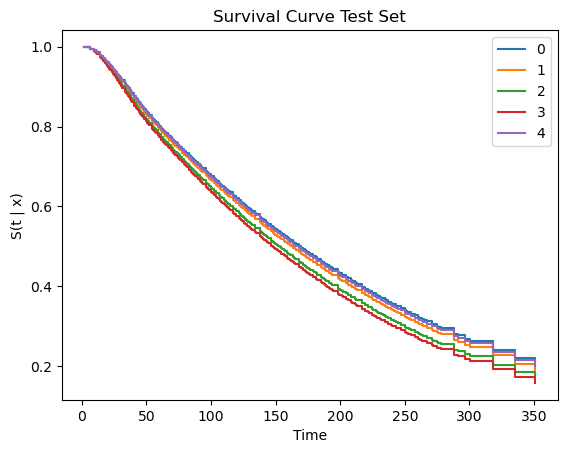

In [ ]:
df_survival_function.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')
plt.title("Survival Curve Test Set")

## Evaluate

In [ ]:
durations_test, events_test = transform_back(y_test)
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev = EvalSurv(df_survival_function, durations_test, events_test, censor_surv='km')
print('Concordance Index',ev.concordance_td('antolini'))

Concordance Index 0.6070646458397773


In [ ]:
print('Integrated Brier Score:',ev.integrated_brier_score(time_grid))

Integrated Brier Score: 0.18551198595050641
